#### Analyzing Neural Time Series Data
Python code for Chapter 14 -- converted from original Matlab by AE Studio (and ChatGPT)\
Original Matlab code by Mike X Cohen

This code accompanies the book, titled "Analyzing Neural Time Series Data" (MIT Press).\
Using the code without following the book may lead to confusion, incorrect data analyses, and misinterpretations of results.\
Mike X Cohen and AE Studio assume no responsibility for inappropriate or incorrect use of this code.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, firls, firwin, filtfilt, lfilter, butter
from scipy.signal.windows import hamming
from scipy.fft import fft, ifft
from scipy.io import loadmat
import time as time_module

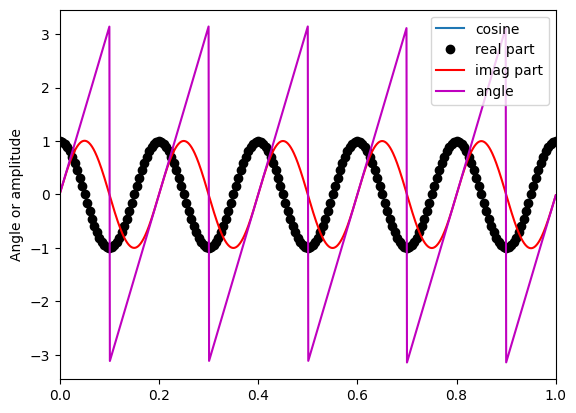

In [2]:
# Figure 14.1

# Create cosine
time = np.arange(0, 1.001, 0.001)
cosine = np.cos(2 * np.pi * 5 * time)

# Plot cosine and its Hilbert transform components
plt.figure()
plt.plot(time, cosine, label='cosine')
plt.plot(time[::5], np.real(hilbert(cosine[::5])), 'ko', label='real part')  # plot every 5th point
plt.plot(time, np.imag(hilbert(cosine)), 'r', label='imag part')
plt.plot(time, np.angle(hilbert(cosine)), 'm', label='angle')
plt.xlim([0, 1])
plt.ylabel('Angle or amplitude')
plt.legend()
plt.show()

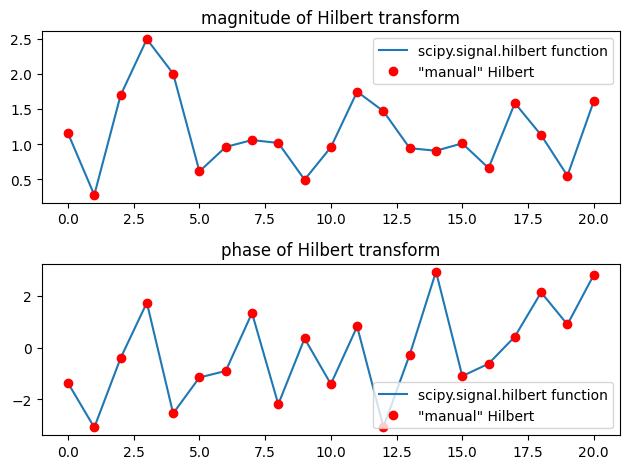

In [3]:
# The FFT-based Hilbert transform

# Generate random numbers
n = 21
randomnumbers = np.random.randn(n)

# Take FFT
f = fft(randomnumbers)

# Create a copy that is multiplied by the complex operator
complexf = 1j * f

# Find indices of positive and negative frequencies
posF = np.arange(1, np.floor(n / 2) + np.mod(n, 2)).astype(int)
negF = np.arange(np.ceil(n / 2) + 1 - np.mod(n, 2), n).astype(int)

# Rotate Fourier coefficients
f[posF] = f[posF] + -1j * complexf[posF]
f[negF] = f[negF] + 1j * complexf[negF]

# The next two lines are an alternative and slightly faster method. 
# The book explains why this is equivalent to the previous two lines.
# f[posF] = f[posF]*2
# f[negF] = f[negF]*0

# Take inverse FFT
hilbertx = ifft(f)

# Compare with scipy.signal.hilbert function
hilbertm = hilbert(randomnumbers, axis=0)

# Plot results
plt.figure()
plt.subplot(211)
plt.plot(np.abs(hilbertm), label='scipy.signal.hilbert function')
plt.plot(np.abs(hilbertx), 'ro', label='"manual" Hilbert')
plt.legend()
plt.title('magnitude of Hilbert transform')

plt.subplot(212)
plt.plot(np.angle(hilbertm), label='scipy.signal.hilbert function')
plt.plot(np.angle(hilbertx), 'ro', label='"manual" Hilbert')
plt.legend()
plt.title('phase of Hilbert transform')

plt.tight_layout()
plt.show()

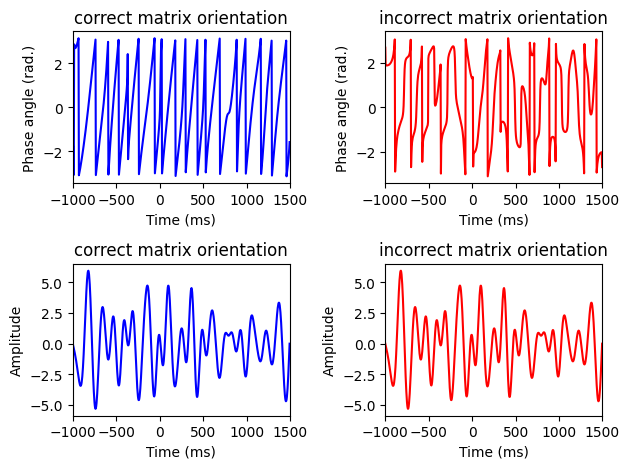

In [4]:
# Figure 14.2

# Load sample EEG data
EEG = loadmat('../data/sampleEEGdata.mat')['EEG'][0, 0]

# Filter parameters
nyquist = EEG['srate'][0][0] / 2
lower_filter_bound = 4  # Hz
upper_filter_bound = 10  # Hz
transition_width = 0.2
filter_order = round(3 * (EEG['srate'][0][0] / lower_filter_bound)) + 1

# Create the filter shape
ffrequencies = [0, (1 - transition_width) * lower_filter_bound, lower_filter_bound,
                upper_filter_bound, (1 + transition_width) * upper_filter_bound, nyquist] / nyquist
idealresponse = [0, 0, 1, 1, 0, 0]
filterweights = firls(filter_order, ffrequencies, idealresponse)

# Apply the filter kernel to the data to obtain the band-pass filtered signal
filtered_data = np.zeros((EEG['nbchan'][0][0], EEG['pnts'][0][0]))
for chani in range(EEG['nbchan'][0][0]):
    filtered_data[chani, :] = filtfilt(filterweights, 1, EEG['data'][chani, :, 0])

# Apply Hilbert transform in correct and incorrect orientations
hilbert_oops = hilbert(filtered_data.T).T
hilbert_yes = hilbert(filtered_data)
# note these are opposite from Matlab

# Plot results
plt.figure()
plt.subplot(221)
plt.plot(EEG['times'][0], np.angle(hilbert_yes[0, :].T), 'b')
plt.title('correct matrix orientation')
plt.xlabel('Time (ms)')
plt.ylabel('Phase angle (rad.)')
plt.xlim([-1000, 1500])

plt.subplot(222)
plt.plot(EEG['times'][0], np.angle(hilbert_oops[0, :]), 'r')
plt.title('incorrect matrix orientation')
plt.xlabel('Time (ms)')
plt.ylabel('Phase angle (rad.)')
plt.xlim([-1000, 1500])

plt.subplot(223)
plt.plot(EEG['times'][0], np.real(hilbert_yes[0, :]), 'b')
plt.title('correct matrix orientation')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.xlim([-1000, 1500])

plt.subplot(224)
plt.plot(EEG['times'][0], np.real(hilbert_oops[0, :]), 'r')
plt.title('incorrect matrix orientation')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.xlim([-1000, 1500])

plt.tight_layout()
plt.show()

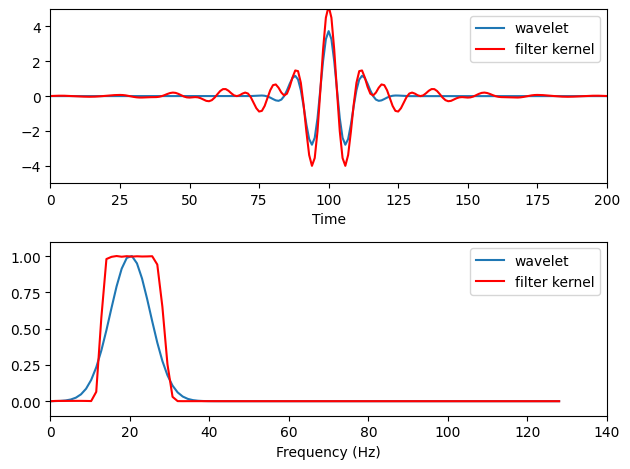

In [5]:
# Figure 14.3

# Define parameters
center_freq = 20  # in Hz
filter_frequency_spread = 6  # Hz +/- the center frequency
wavelet_frequency_spread = 4  # number of wavelet cycles

# Create wavelet
time = np.arange(-1000 / EEG['srate'][0][0] / 10, 1000 / EEG['srate'][0][0] / 10 + 1 / EEG['srate'][0][0], 1 / EEG['srate'][0][0])
wavelet = np.exp(2 * 1j * np.pi * center_freq * time) * np.exp(-time**2 / (2 * (wavelet_frequency_spread / (2 * np.pi * center_freq))**2))
wavelet = (wavelet - np.mean(wavelet)) / np.std(wavelet)  # z-score

# Compute its power spectrum
fft_wavelet = np.abs(fft(wavelet))
fft_wavelet = fft_wavelet / np.max(fft_wavelet)  # normalized to 1.0 for visual comparison ease
hz_wavelet = np.linspace(0, nyquist, int(len(time) / 2) + 1)

# Construct filter kernel
transition_width = 0.2
ffrequencies = [0, (1 - transition_width) * (center_freq - filter_frequency_spread),
                center_freq - filter_frequency_spread, center_freq + filter_frequency_spread,
                (1 + transition_width) * (center_freq + filter_frequency_spread), nyquist] / nyquist
idealresponse = [0, 0, 1, 1, 0, 0]
filterweights = firls(201, ffrequencies, idealresponse)
filterweights = (filterweights - np.mean(filterweights)) / np.std(filterweights)  # z-score
# Also compute weights using firwin
filterweights1 = firwin(201, [center_freq - filter_frequency_spread, center_freq + filter_frequency_spread] / nyquist, pass_zero=False)
filterweights1 = (filterweights1 - np.mean(filterweights1)) / np.std(filterweights1)  # z-score

# Compute power spectrum of filter kernel
fft_filtkern = np.abs(fft(filterweights))
fft_filtkern = fft_filtkern / np.max(fft_filtkern)  # normalized to 1.0 for visual comparison ease
fft_filtkern1 = np.abs(fft(filterweights1))
fft_filtkern1 = fft_filtkern1 / np.max(fft_filtkern1)  # normalized to 1.0 for visual comparison ease

hz_filtkern = np.linspace(0, nyquist, 101)  # list of frequencies in Hz corresponding to filter kernel

# Plot wavelet and filter kernel
plt.figure()
plt.subplot(211)
plt.plot(np.real(wavelet), label='wavelet')
plt.plot(filterweights, 'r', label='filter kernel')
plt.xlim([0, 200])
plt.ylim([-5, 5])
plt.xlabel('Time')
plt.legend()

# Plot power spectra
plt.subplot(212)
plt.plot(hz_wavelet, fft_wavelet[:int(np.ceil(len(fft_wavelet) / 2))], label='wavelet')
plt.plot(hz_filtkern, fft_filtkern[:int(np.ceil(len(fft_filtkern) / 2))], 'r', label='filter kernel')
plt.xlim([0, 140])
plt.ylim([-.1, 1.1])
plt.xlabel('Frequency (Hz)')
plt.legend()

plt.tight_layout()
plt.show()

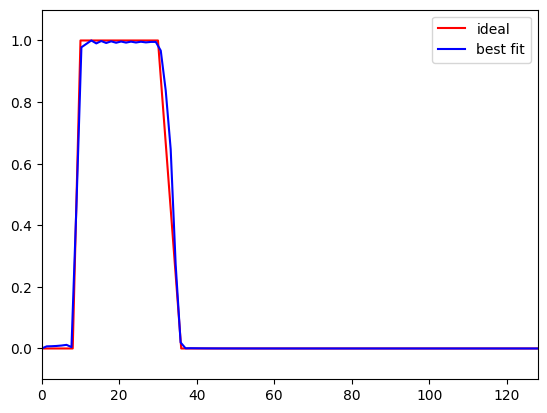

In [6]:
# Figure 14.4

# Define parameters
center_freq = 20  # in Hz
filter_frequency_spread_wide = 10  # Hz +/- the center frequency

# Construct filter kernel
ffrequencies = [0, (1 - transition_width) * (center_freq - filter_frequency_spread_wide),
                center_freq - filter_frequency_spread_wide, center_freq + filter_frequency_spread_wide,
                (1 + transition_width) * (center_freq + filter_frequency_spread_wide), nyquist] / nyquist
idealresponse = [0, 0, 1, 1, 0, 0]
filterweightsW = firls(201, ffrequencies, idealresponse)
filterweightsW = (filterweightsW - np.mean(filterweightsW)) / np.std(filterweightsW)  # z-score

# Compute power spectrum of filter kernel
fft_filtkern = np.abs(fft(filterweightsW))
fft_filtkern = fft_filtkern / np.max(fft_filtkern)  # normalized to 1.0 for visual comparison ease

# Plot ideal response and best fit
plt.figure()
plt.plot(ffrequencies * nyquist, idealresponse, 'r', label='ideal')
plt.plot(hz_filtkern, fft_filtkern[:int(np.ceil(len(fft_filtkern) / 2))], 'b', label='best fit')
plt.ylim([-.1, 1.1])
plt.xlim([0, nyquist])
plt.legend()
plt.show()

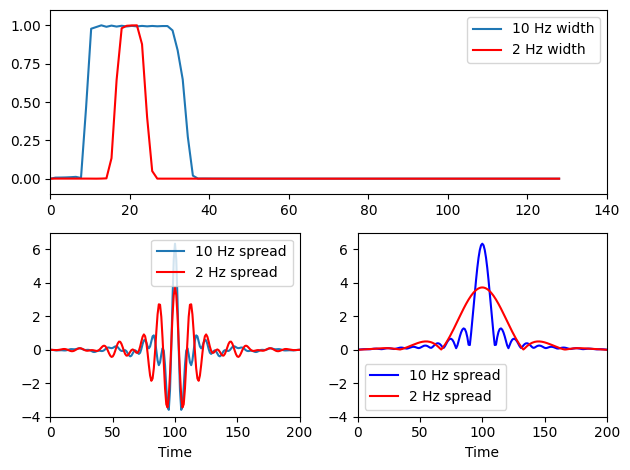

In [7]:
# Figure 14.5

# Define parameters
center_freq = 20  # in Hz
filter_frequency_spread_wide = 10  # Hz +/- the center frequency
filter_frequency_spread_naro = 2   # Hz +/- the center frequency

# Construct wide filter kernel
ffrequencies = [0, (1 - transition_width) * (center_freq - filter_frequency_spread_wide),
                 center_freq - filter_frequency_spread_wide, center_freq + filter_frequency_spread_wide,
                 (1 + transition_width) * (center_freq + filter_frequency_spread_wide), nyquist] / nyquist
idealresponse = [0, 0, 1, 1, 0, 0]
filterweightsW = firls(201, ffrequencies, idealresponse)
filterweightsW = (filterweightsW - np.mean(filterweightsW)) / np.std(filterweightsW)  # z-score

# Construct narrow filter kernel
ffrequencies = [0, (1 - transition_width) * (center_freq - filter_frequency_spread_naro),
                 center_freq - filter_frequency_spread_naro, center_freq + filter_frequency_spread_naro,
                 (1 + transition_width) * (center_freq + filter_frequency_spread_naro), nyquist] / nyquist
idealresponse = [0, 0, 1, 1, 0, 0]
filterweightsN = firls(201, ffrequencies, idealresponse)
filterweightsN = (filterweightsN - np.mean(filterweightsN)) / np.std(filterweightsN)  # z-score

# Plot filter kernels and their Hilbert transforms
plt.figure()
plt.subplot(211)
fft_filtkern = np.abs(fft(filterweightsW))
fft_filtkern = fft_filtkern / np.max(fft_filtkern)  # normalized to 1.0 for visual comparison ease
plt.plot(hz_filtkern, fft_filtkern[:int(np.ceil(len(fft_filtkern) / 2))])

fft_filtkern = np.abs(fft(filterweightsN))
fft_filtkern = fft_filtkern / np.max(fft_filtkern)  # normalized to 1.0 for visual comparison ease
plt.plot(hz_filtkern, fft_filtkern[:int(np.ceil(len(fft_filtkern) / 2))], 'r')
plt.xlim([0, 140])
plt.ylim([-.1, 1.1])
plt.legend(['10 Hz width', '2 Hz width'])

plt.subplot(223)
plt.plot(filterweightsW)
plt.plot(filterweightsN, 'r')
plt.xlim([0, 200])
plt.ylim([-4, 7])
plt.legend(['10 Hz spread', '2 Hz spread'])
plt.xlabel('Time')

plt.subplot(224)
plt.plot(np.abs(hilbert(filterweightsW)), 'b')
plt.plot(np.abs(hilbert(filterweightsN)), 'r')
plt.xlim([0, 200])
plt.ylim([-4, 7])
plt.legend(['10 Hz spread', '2 Hz spread'])
plt.xlabel('Time')

plt.tight_layout()
plt.show()

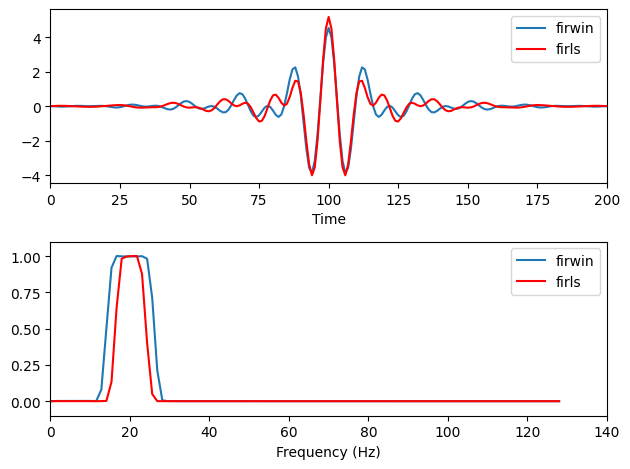

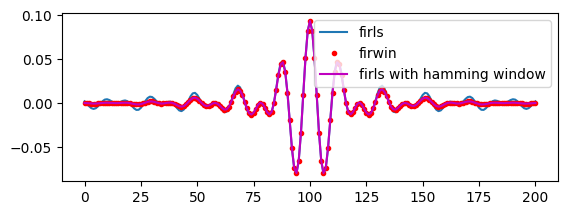

In [8]:
# Figure 14.6

# Plot filter kernels and their power spectra
plt.figure()
plt.subplot(211)
plt.plot(filterweights1, label='firwin')
plt.plot(filterweights, 'r', label='firls')
plt.xlim([0, 200])
plt.xlabel('Time')
plt.legend()

plt.subplot(212)
plt.plot(hz_filtkern, fft_filtkern1[:int(np.ceil(len(fft_filtkern1) / 2))], label='firwin')
plt.plot(hz_filtkern, fft_filtkern[:int(np.ceil(len(fft_filtkern) / 2))], 'r', label='firls')
plt.xlim([0, 140])
plt.ylim([-.1, 1.1])
plt.xlabel('Frequency (Hz)')
plt.legend()

plt.tight_layout()
plt.show()

# This next figure shows that the filter kernel computed by firwin is the same as
# that produced by firls if you set the transition zone to zero and then
# smooth the filter kernel with a Hamming window. In the plot, the red and magenta
# lines overlap, which is why you don't see the firwin filter kernel. You can
# subtract them and show that the difference (which is due to re-scaling 
# of the kernel after windowing) is 3-4 orders of magnitude smaller than
# the kernel itself, hence, nearly identical.

freqL = center_freq - filter_frequency_spread
freqU = center_freq + filter_frequency_spread

ffrequencies = [0, freqL, freqL, freqU, freqU, nyquist] / nyquist
filterweights = firls(201, ffrequencies, idealresponse)
filterweights1 = firwin(201, [freqL, freqU] / nyquist, pass_zero=False)

plt.figure()
plt.subplot(211)
plt.plot(filterweights, label='firls')
plt.plot(filterweights1, 'r.', label='firwin')
plt.plot(filterweights * hamming(len(filterweights)), 'm', label='firls with hamming window')
plt.legend()
plt.show()

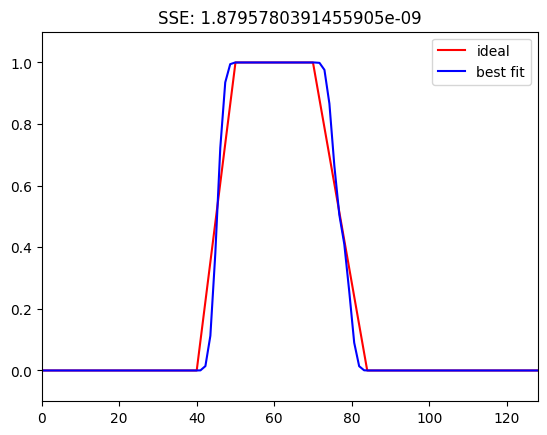

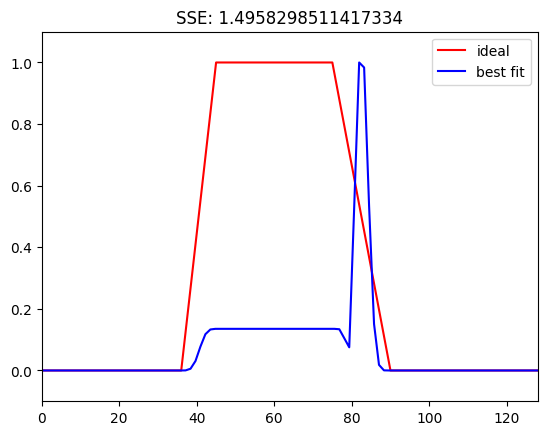

In [9]:
# Figure 14.7a

# Define parameters
center_freq = 60  # in Hz
filter_frequency_spread_wide = 10  # Hz +/- the center frequency

# Construct filter kernel
ffrequencies = [0, (1 - transition_width) * (center_freq - filter_frequency_spread_wide),
                center_freq - filter_frequency_spread_wide, center_freq + filter_frequency_spread_wide,
                (1 + transition_width) * (center_freq + filter_frequency_spread_wide), nyquist] / nyquist
idealresponse = [0, 0, 1, 1, 0, 0]
filterweightsW = firls(201, ffrequencies, idealresponse)
filterweightsW = (filterweightsW - np.mean(filterweightsW)) / np.std(filterweightsW)  # z-score

# Compute power spectrum of filter kernel
fft_filtkern = np.abs(fft(filterweightsW))
fft_filtkern = fft_filtkern / np.max(fft_filtkern)  # normalized to 1.0 for visual comparison ease

# Plot ideal response and best fit
plt.figure()
plt.plot(ffrequencies * nyquist, idealresponse, 'r', label='ideal')
plt.plot(hz_filtkern, fft_filtkern[:int(np.ceil(len(fft_filtkern) / 2))], 'b', label='best fit')
plt.ylim([-.1, 1.1])
plt.xlim([0, nyquist])
plt.legend()

# Calculate and display SSE (sum of squared errors)
freqsidx = [np.argmin(np.abs(hz_filtkern - f)) for f in ffrequencies * nyquist]
sse = np.sum((idealresponse - fft_filtkern[freqsidx])**2)
plt.title(f'SSE: {sse}')
plt.show()


# Define parameters
center_freq = 60  # in Hz
filter_frequency_spread_wide = 15  # Hz +/- the center frequency

# Construct filter kernel
ffrequencies = [0, (1 - transition_width) * (center_freq - filter_frequency_spread_wide),
                center_freq - filter_frequency_spread_wide, center_freq + filter_frequency_spread_wide,
                (1 + transition_width) * (center_freq + filter_frequency_spread_wide), nyquist] / nyquist
idealresponse = [0, 0, 1, 1, 0, 0]
filterweightsW = firls(201, ffrequencies, idealresponse)
filterweightsW = (filterweightsW - np.mean(filterweightsW)) / np.std(filterweightsW)  # z-score

# Compute power spectrum of filter kernel
fft_filtkern = np.abs(fft(filterweightsW))
fft_filtkern = fft_filtkern / np.max(fft_filtkern)  # normalized to 1.0 for visual comparison ease

# Plot ideal response and best fit
plt.figure()
plt.plot(ffrequencies * nyquist, idealresponse, 'r', label='ideal')
plt.plot(hz_filtkern, fft_filtkern[:int(np.ceil(len(fft_filtkern) / 2))], 'b', label='best fit')
plt.ylim([-.1, 1.1])
plt.xlim([0, nyquist])
plt.legend()

# Calculate and display SSE (sum of squared errors)
freqsidx = [np.argmin(np.abs(hz_filtkern - f)) for f in ffrequencies * nyquist]
sse = np.sum((idealresponse - fft_filtkern[freqsidx])**2)
plt.title(f'SSE: {sse}')
plt.show()

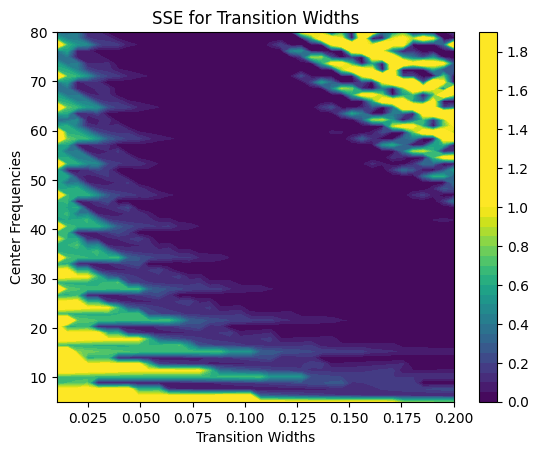

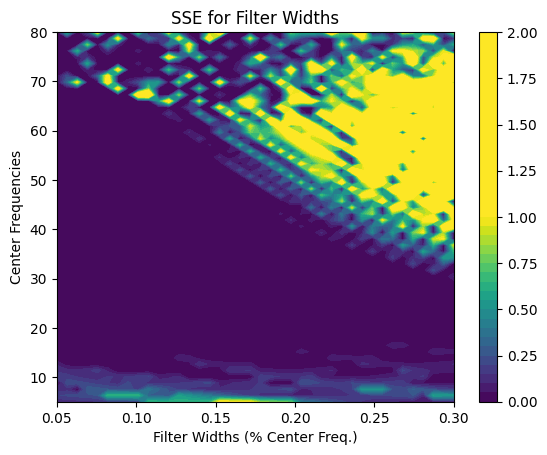

In [10]:
# Figure 14.7b

# Define parameters
centerfreqs = np.linspace(5, 80, 60)
transwidths = np.linspace(0.01, 0.2, 40)
filterwidths = np.linspace(0.05, 0.3, 40)

# Initialize SSE matrix for transition widths
sse = np.zeros((len(centerfreqs), len(transwidths)))
for centfreqi, center_freq in enumerate(centerfreqs):
    for transwidi, transition_width in enumerate(transwidths):
        filter_frequency_spread_wide = center_freq * 0.2

        ffrequencies = [0, (1 - transition_width) * (center_freq - filter_frequency_spread_wide),
                        center_freq - filter_frequency_spread_wide, center_freq + filter_frequency_spread_wide,
                        (1 + transition_width) * (center_freq + filter_frequency_spread_wide), nyquist] / nyquist
        filterweightsW = firls(201, ffrequencies, idealresponse)
        filterweightsW = (filterweightsW - np.mean(filterweightsW)) / np.std(filterweightsW)  # z-score

        fft_filtkern = np.abs(fft(filterweightsW))
        fft_filtkern = fft_filtkern / np.max(fft_filtkern)
        freqsidx = [np.argmin(np.abs(hz_filtkern - f)) for f in ffrequencies * nyquist]
        
        sse[centfreqi, transwidi] = np.sum((idealresponse - fft_filtkern[freqsidx])**2)

# Plot SSE for transition widths
plt.figure()
plt.contourf(transwidths, centerfreqs, sse, 40, cmap='viridis')
plt.xlabel('Transition Widths')
plt.ylabel('Center Frequencies')
plt.clim([0, 1])
plt.colorbar()
plt.title('SSE for Transition Widths')
plt.show()

# Initialize SSE matrix for filter widths
sse = np.zeros((len(centerfreqs), len(filterwidths)))
for centfreqi, center_freq in enumerate(centerfreqs):
    for filterwidthi, filter_width in enumerate(filterwidths):
        filter_frequency_spread_wide = center_freq * filter_width
        transition_width = 0.2

        ffrequencies = [0, (1 - transition_width) * (center_freq - filter_frequency_spread_wide),
                        center_freq - filter_frequency_spread_wide, center_freq + filter_frequency_spread_wide,
                        (1 + transition_width) * (center_freq + filter_frequency_spread_wide), nyquist] / nyquist
        filterweightsW = firls(201, ffrequencies, idealresponse)
        filterweightsW = (filterweightsW - np.mean(filterweightsW)) / np.std(filterweightsW)  # z-score

        fft_filtkern = np.abs(fft(filterweightsW))
        fft_filtkern = fft_filtkern / np.max(fft_filtkern)
        freqsidx = [np.argmin(np.abs(hz_filtkern - f)) for f in ffrequencies * nyquist]

        sse[centfreqi, filterwidthi] = np.sum((idealresponse - fft_filtkern[freqsidx])**2)

# Plot SSE for filter widths
plt.figure()
plt.contourf(filterwidths, centerfreqs, sse, 40, cmap='viridis')
plt.xlabel('Filter Widths (% Center Freq.)')
plt.ylabel('Center Frequencies')
plt.clim([0, 1])
plt.colorbar()
plt.title('SSE for Filter Widths')
plt.show()

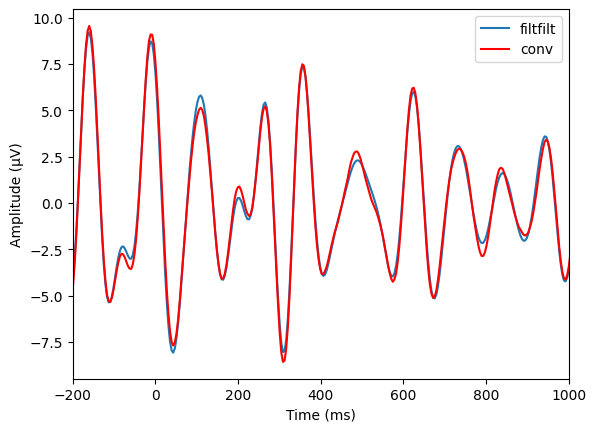

In [11]:
# Figure 14.8

# Define parameters
center_freq = 10
freqspread = 4  # Hz +/- the center frequency
transwid = 0.10
ffrequencies = [0, (1 - transwid) * (center_freq - freqspread), (center_freq - freqspread),
                (center_freq + freqspread), (1 + transwid) * (center_freq + freqspread), nyquist] / nyquist

# Data to filter
data2filter = EEG['data'][46, :, 0]
filterweights = firls(201, ffrequencies, idealresponse)
 
# Filter the data using filtfilt and convolve
filter_result = filtfilt(filterweights, 1, data2filter)
convol_result = np.convolve(data2filter, filterweights, 'same')

# Plot the results
plt.figure()
plt.plot(EEG['times'][0], filter_result, label='filtfilt')
plt.plot(EEG['times'][0], convol_result, 'r', label='conv')
plt.xlim([-200, 1000])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (μV)')
plt.legend()
plt.show()

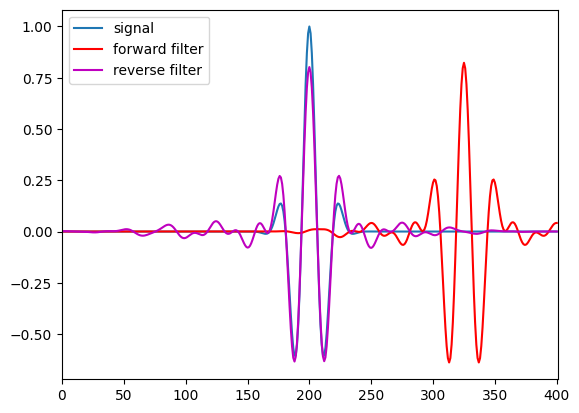

In [12]:
# Figure 14.9

# Define parameters
center_freq = 10  # in Hz
nyquist = EEG['srate'][0][0] / 2

# Create short sine wave
time = np.arange(-2000 / EEG['srate'][0][0] / 10, 2000 / EEG['srate'][0][0] / 10 + 1 / EEG['srate'][0][0], 1 / EEG['srate'][0][0])
wavelet = np.cos(2 * np.pi * center_freq * time) * np.exp(-time**2 / (2 * (3 / (2 * np.pi * center_freq))**2))

freqspread = 4  # Hz +/- the center frequency
transwid = 0.10

# Construct filter kernels
ffrequencies = [0, (1 - transwid) * (center_freq - freqspread), (center_freq - freqspread),
                (center_freq + freqspread), (1 + transwid) * (center_freq + freqspread), nyquist] / nyquist
idealresponse = [0, 0, 1, 1, 0, 0]
filterweights = firls(251, ffrequencies, idealresponse)

# Apply forward and reverse filtering
forward_filt = lfilter(filterweights, 1, wavelet)
reverse_filt = lfilter(filterweights, 1, forward_filt[::-1])
final_filt_result = reverse_filt[::-1]  # Reverse time again

# Plot the results
plt.figure()
plt.plot(wavelet, label='signal')
plt.plot(forward_filt, 'r', label='forward filter')
plt.plot(final_filt_result, 'm', label='reverse filter')
plt.xlim([0, len(wavelet)])
plt.legend()
plt.show()

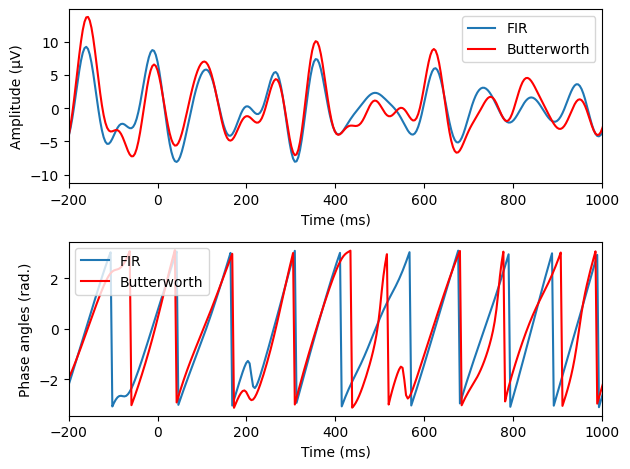

In [13]:
# Figure 14.10

# 5th-order Butterworth filter
butterB, butterA = butter(5, [(center_freq - filter_frequency_spread) / nyquist, (center_freq + filter_frequency_spread) / nyquist], btype='bandpass')
butter_filter = filtfilt(butterB, butterA, data2filter)

# Plot the real part of the filtered signal
plt.figure()
plt.subplot(211)
plt.plot(EEG['times'][0], filter_result, label='FIR')
plt.plot(EEG['times'][0], butter_filter, 'r', label='Butterworth')
plt.xlim([-200, 1000])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (μV)')
plt.legend()

# Now plot phases
plt.subplot(212)
plt.plot(EEG['times'][0], np.angle(hilbert(filter_result)), label='FIR')
plt.plot(EEG['times'][0], np.angle(hilbert(butter_filter)), 'r', label='Butterworth')
plt.xlim([-200, 1000])
plt.xlabel('Time (ms)')
plt.ylabel('Phase angles (rad.)')
plt.legend()

plt.tight_layout()
plt.show()

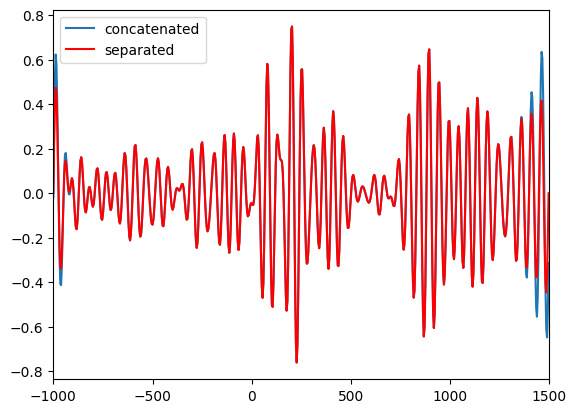

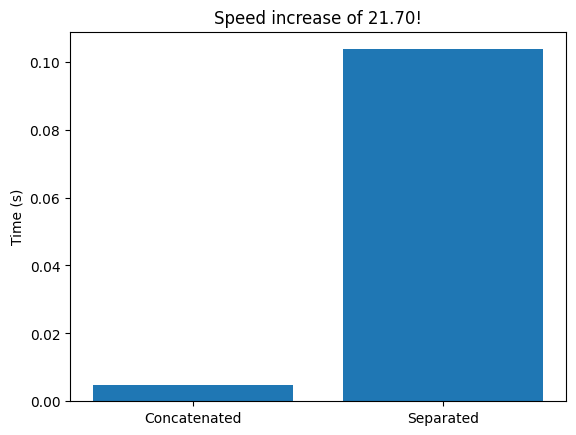

In [14]:
# Figure 14.12

# Define parameters
elap_time = [0, 0]
num_iter = 100

freqspread = 4  # Hz +/- the center frequency
center_freq = 20
transwid = 0.15

# Construct filter kernel
ffrequencies = [0, (1 - transwid) * (center_freq - freqspread), (center_freq - freqspread),
                (center_freq + freqspread), (1 + transwid) * (center_freq + freqspread), nyquist] / nyquist
idealresponse = [0, 0, 1, 1, 0, 0]
filterweights = firls(3 * round(EEG['srate'][0][0] / (center_freq - freqspread)) + 1, ffrequencies, idealresponse)

# Concatenated filtering
for i in range(num_iter):
    start_time = time_module.time()
    data2filter_cat = EEG['data'][46, :, :].flatten('F')
    filtdat_cat = np.reshape(filtfilt(filterweights, 1, data2filter_cat), (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')
    elap_time[0] += time_module.time() - start_time

# Separated filtering
for i in range(num_iter):
    start_time = time_module.time()
    data2filter_sep = EEG['data'][46, :, :]
    filtdat_sep = np.zeros_like(data2filter_sep)
    for triali in range(EEG['trials'][0][0]):
        filtdat_sep[:, triali] = filtfilt(filterweights, 1, data2filter_sep[:, triali])
    elap_time[1] += time_module.time() - start_time

elap_time = np.array(elap_time) / num_iter

# Plot
plt.figure()
plt.plot(EEG['times'][0], np.mean(filtdat_cat, axis=1), label='concatenated')
plt.plot(EEG['times'][0], np.mean(filtdat_sep, axis=1), 'r', label='separated')
plt.xlim([-1000, 1500])
plt.legend()
plt.show()

plt.figure()
plt.bar([0, 1], elap_time)
plt.xticks([0, 1], ['Concatenated', 'Separated'])
plt.ylabel('Time (s)')
plt.title(f'Speed increase of {elap_time[1] / elap_time[0]:.2f}!')
plt.show()